In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from config import cache_path, save_path
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

boc = BrainObservatoryCache(manifest_file=str(
            Path(cache_path) / 'brain_observatory_manifest.json'))

eid=501559087
#eid=564425777
eid=567734055

data_dct={}

data_set = boc.get_ophys_experiment_data(eid)

data_dct['movie_stim_table'] = data_set.get_stimulus_table(
                'natural_movie_one')

data_dct['neural_responses'] = data_set.get_dff_traces()[1]

embeddings=np.load(Path(save_path)/Path('natural_movie_one_dino.npy'))
#embeddings=np.load(Path(save_path)/Path('movie_one.npy'))
print(embeddings.shape)
embeddings=np.load('/home/maria/CalciumImaging/movie_one_dino.npy')
#embeddings=np.load(Path(save_path)/Path('natural_movie_one_clip.npy'))

def make_regression_data(data_dct, embeddings):
        np.random.seed = 7879
        stimuli = data_dct['movie_stim_table'].loc[data_dct['movie_stim_table']['repeat'] == 9]
        print(stimuli)

        X_train, X_test, y_train_inds, y_test_inds = train_test_split(embeddings,stimuli['start'].values, test_size=0.7, random_state=42)
        y_train=data_dct['neural_responses'][:,y_train_inds]
        y_test=data_dct['neural_responses'][:,y_test_inds]

        return y_train, y_test, X_train, X_test

y_train_movie, y_test_movie, train_embedding,test_embedding = make_regression_data(data_dct, embeddings) 
print(y_train_movie.shape, y_test_movie.shape, train_embedding.shape, test_embedding.shape)

(900, 768)
      frame  start    end  repeat
8100      0  78621  78621       9
8101      1  78622  78622       9
8102      2  78623  78623       9
8103      3  78624  78624       9
8104      4  78625  78625       9
...     ...    ...    ...     ...
8995    895  79521  79521       9
8996    896  79522  79522       9
8997    897  79523  79523       9
8998    898  79524  79524       9
8999    899  79525  79525       9

[900 rows x 4 columns]
(241, 270) (241, 630) (270, 768) (630, 768)


R-squared score: -0.41437792326288264
0.23040877630367906
-0.7714059372295043
-1.1396685476360977
0.8637205815900335
-0.8724492317561505
-0.9111916806382829
0.8367580644327278
-0.9049980070266401
0.6257457496498122
-1.0812346308642997
-0.7670513909135199
-0.5846275446763882
-0.32536851066041006
-0.18851351247854242
-1.1564899355429805
-1.012556420597381
0.7616579605618568
-0.6129716100954936
-1.0379009740276053
-0.5344060221682074
-0.7186223422233087
-0.4208634047167852
-0.7233845093293736
-0.674103201336685
-0.7170958515036827
-0.32203553180533073
-0.7775900570998298
-0.09116434213089408
0.6940354770809342
-0.7817602523867366
-0.6723080200127087
-0.009247604438651802
-0.38575497791624924
-0.8935197929625953
-0.6911575397523697
-1.3469565495501978
0.7245918232874811
-0.6297029312667664
-0.01776728577245046
-0.7738635647296388
0.2266885858586588
-0.6048534099140308
0.47250373020708214
-0.11362073672673545
-0.6406161009615108
-0.8818592276542787
-1.1784855612823946
-0.036411271989467364


(array([ 6., 34., 70., 47., 14., 16., 13., 11., 14., 16.]),
 array([-1.34695655, -1.11831252, -0.8896685 , -0.66102447, -0.43238045,
        -0.20373642,  0.02490761,  0.25355163,  0.48219566,  0.71083968,
         0.93948371]),
 <BarContainer object of 10 artists>)

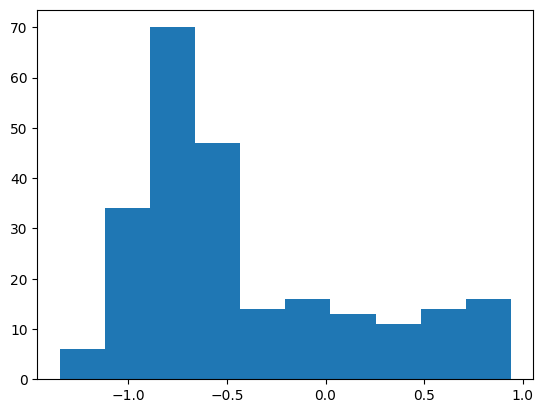

In [2]:
# Create a Linear Regression model
regr = LinearRegression()
regr=Ridge(10)

# Fit the model with scaled training features and target variable
regr.fit(train_embedding, y_train_movie.T)

# Make predictions on scaled test features
predictions = regr.predict(test_embedding)

# Calculate R-squared score
r2 = r2_score(y_test_movie.T, predictions)

print("R-squared score:", r2)

scores=[]
for i in range(0,y_test_movie.shape[0]):
    scores.append(r2_score(y_test_movie.T[:,i], predictions[:,i]))
    print(r2_score(y_test_movie.T[:,i], predictions[:,i]))

    import matplotlib.pyplot as plt


plt.hist(scores)

In [23]:
test_embedding.shape
#regr.coef_.shape

(630, 768)

In [20]:
A=np.multiply(regr.coef_[0,:], test_embedding)
print(A.shape)

(630, 768)


In [21]:
pca=PCA(n_components=30)
trn=pca.fit_transform(train_embedding)
print(train_embedding.shape, test_embedding.shape)
tst=pca.transform(test_embedding)
A_emb=pca.transform(A)
#coef=pca.transform(regr.coef_)
#print(tst.shape)
#print(tst.shape)

(270, 768) (630, 768)


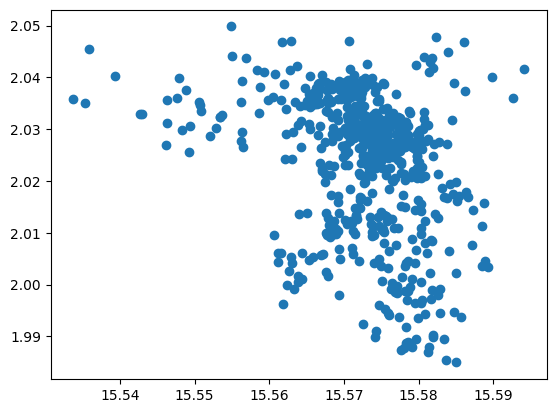

In [22]:
plt.scatter(A_emb[:,0],A_emb[:,1])
#plt.scatter(tst[:,0],tst[:,1])

In [25]:
(regr.coef_@regr.coef_.T).shape

(241, 241)

In [26]:
regr.coef_.shape

(241, 768)

In [30]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=3)
cl=km.fit_transform(regr.coef_.T)
print(cl.shape)
print(cl)
sim=(regr.coef_@regr.coef_.T)

/home/maria/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(768, 3)
[[0.07892654 0.08410893 0.08958768]
 [0.09624425 0.07556656 0.08547754]
 [0.0816398  0.09011861 0.09237366]
 ...
 [0.08302669 0.07810567 0.08728789]
 [0.08042845 0.09063723 0.0784571 ]
 [0.09084889 0.0752554  0.07308966]]


In [42]:
regr.coef_.shape

(241, 768)

<Axes: >

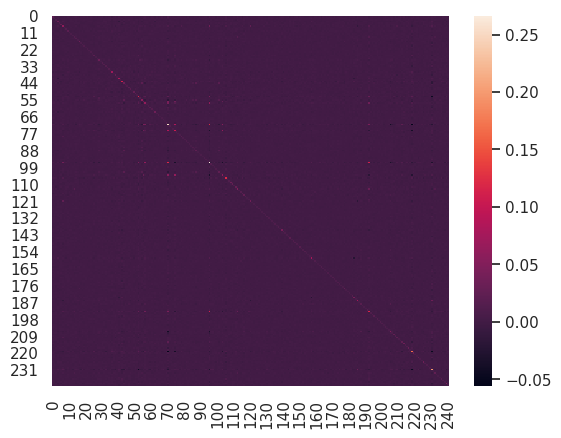

In [48]:
a=regr.coef_@regr.coef_.T
sns.heatmap(a)

/home/maria/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


241
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240  70  95 192]


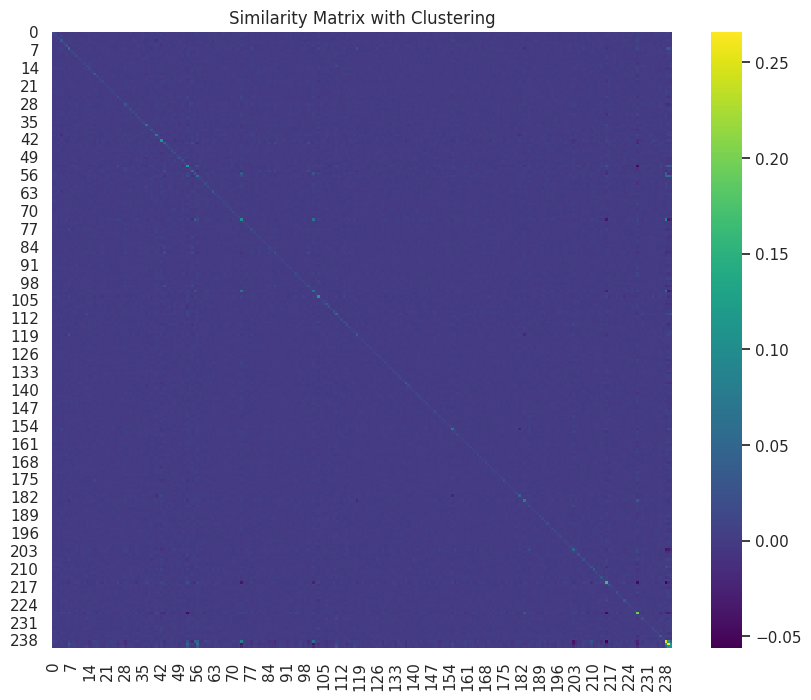

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming 'regr' is your linear regression model

# Perform KMeans clustering
km = KMeans(n_clusters=3, random_state=42)
cluster_labels = km.fit_predict(regr.coef_)
print(len(cluster_labels))

# Get the clustered indices
clustered_indices =np.array(sorted(range(len(cluster_labels)), key=lambda k: cluster_labels[k]))
print(clustered_indices)

# Arrange the similarity matrix based on clustering
similarity_matrix_clustered = regr.coef_[clustered_indices] @ regr.coef_[clustered_indices].T
similarity_matrix_clustered.shape
# Create a heatmap using seaborn
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_clustered, cmap='viridis')#, annot=True, fmt=".2f", xticklabels=clustered_indices, yticklabels=clustered_indices)
plt.title('Similarity Matrix with Clustering')
plt.show()

<Axes: >

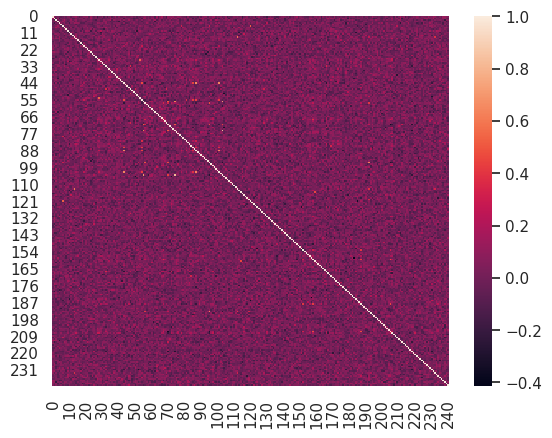

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

pw=cosine_similarity(regr.coef_)


sns.heatmap(pw)

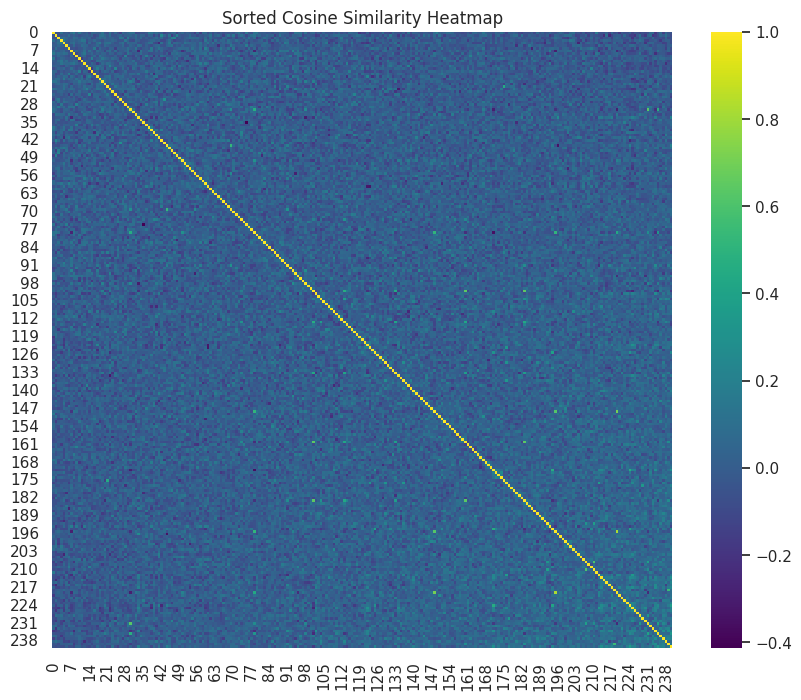

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'regr' is your linear regression model

# Calculate cosine similarity
pw = cosine_similarity(regr.coef_)

# Get the indices for sorting based on the sum of cosine similarities for each row
sorted_indices = np.argsort(np.sum(pw, axis=1))

# Sort the cosine similarity matrix
sorted_pw = pw[sorted_indices][:, sorted_indices]

# Create a heatmap using seaborn
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_pw, cmap='viridis')#, annot=True, fmt=".2f", xticklabels=sorted_indices, yticklabels=sorted_indices)
plt.title('Sorted Cosine Similarity Heatmap')
plt.show()


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+01, 6.000e+00, 8.000e+00, 2.200e+01,
        2.800e+01, 4.800e+01, 5.600e+01, 9.000e+01, 1.480e+02, 2.700e+02,
        3.560e+02, 6.000e+02, 7.980e+02, 1.174e+03, 1.584e+03, 1.984e+03,
        2.514e+03, 3.066e+03, 3.508e+03, 4.090e+03, 4.156e+03, 4.338e+03,
        4.468e+03, 4.184e+03, 4.036e+03, 3.566e+03, 2.944e+03, 2.498e+03,
        1.942e+03, 1.588e+03, 1.144e+03, 7.720e+02, 5.480e+02, 3.940e+02,
        2.940e+02, 1.740e+02, 1.240e+02, 7.200e+01, 5.000e+01, 2.400e+01,
        3.400e+01, 1.600e+01, 1.200e+01, 8.000e+00, 6.000e+00, 1.000e+01,
        0.000e+00, 1.000e+01, 2.000e+00, 4.000e+00, 4.000e+00, 6.000e+00,
        4.000e+00, 2.000e+00, 8.000e+00, 2.000e+00, 0.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

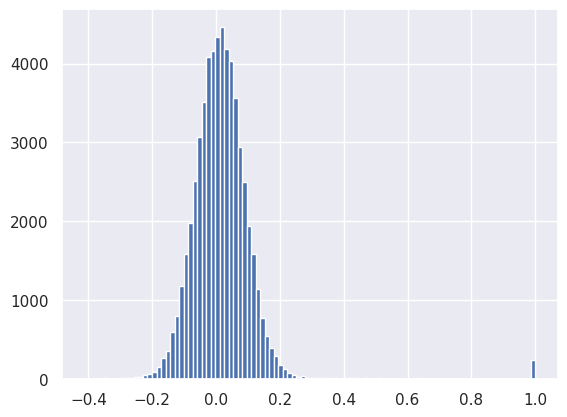

In [5]:
pw = cosine_similarity(regr.coef_)
plt.hist(pw.flatten(),bins=100)

In [6]:
from scipy import sparse


def ideal_data(num, dimX, dimY, rrank, noise=1):
    """Low rank data"""
    X = np.random.randn(num, dimX)
    W = np.dot(np.random.randn(dimX, rrank), np.random.randn(rrank, dimY))
    Y = np.dot(X, W) + np.random.randn(num, dimY) * noise
    return X, Y


class ReducedRankRegressor(object):
    """
    Reduced Rank Regressor (linear 'bottlenecking' or 'multitask learning')
    - X is an n-by-d matrix of features.
    - Y is an n-by-D matrix of targets.
    - rrank is a rank constraint.
    - reg is a regularization parameter (optional).
    """
    def __init__(self, X, Y, rank, reg=None):
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        if np.size(np.shape(Y)) == 1:
            Y = np.reshape(Y, (
                -1, 1))
        if reg is None:
            reg = 0
        self.rank = rank

        CXX = np.dot(X.T, X) + reg * sparse.eye(np.size(X, 1))
        CXY = np.dot(X.T, Y)
        _U, _S, V = np.linalg.svd(np.dot(CXY.T, np.dot(np.linalg.pinv(CXX), CXY)))
        self.W = V[0:rank, :].T
        self.A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, self.W)).T

    def __str__(self):
        return 'Reduced Rank Regressor (rank = {})'.format(self.rank)

    def predict(self, X):
        """Predict Y from X."""
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        return np.dot(X, np.dot(self.A.T, self.W.T))

In [ ]:
ReducedRankRegressor()